In [1]:
import dask, concurrent.futures, time, warnings, os, re, pickle
from osgeo import gdal
import os
import requests as r
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import rioxarray as riox
import time
import xarray as xr
from urllib.request import urlopen
from xml.etree.ElementTree import parse,fromstring
from pandas import to_datetime
from rasterio.crs import CRS
from datetime import datetime, timedelta
from netrc import netrc
from pyproj import Proj
from src.hls_funcs import fetch
from src.hls_funcs.masks import mask_hls, shp2mask, bolton_mask
from src.hls_funcs.indices import ndvi_func
from src.hls_funcs.smooth import smooth_xr, despike_ts_xr
import cartopy.crs as ccrs
from rasterio.plot import show
from src.hls_funcs.predict import pred_bm, pred_bm_se, pred_cov
import dask.diagnostics
import matplotlib.pyplot as plt

ERROR 1: PROJ: proj_create_from_database: Open of /project/cper_neon_aop/conda_envs/hls_nrt_env/share/proj failed


In [2]:
#wkDIR = os.getcwd()
#outDIR_base = 'data/hls_nrt/'

wkDIR = '/project/cper_neon_aop/hls_nrt/'
outDIR_base = '/90daydata/cper_neon_aop/hls_nrt/'

cluster_loc = 'hpc'

In [3]:
yr = 2021
#prefix = 'redtop' 
#prefix = 'cper'
prefix = 'tbng'

if prefix == 'cper': 
    aoi_f = os.path.join('data/ground/cper_pastures_2017_clip.shp')
    df_aoi = gpd.read_file(aoi_f)
    subunit_name_old = 'Past_Name_'
    subunit_name = 'Pasture'
elif prefix == 'redtop':
    from src.utils.convert import kmz_to_shp
    df_aoi = kmz_to_shp('data/ground/RedTop_Boundary.kmz', 'data/ground/')
    df_aoi = df_aoi.to_crs(epsg=32613)
    subunit_name_old = None
    subunit_name = None
elif prefix == 'tbng':
    df_aoi_txt = pd.read_csv('/project/cper_neon_aop/tbng_veg/data/bm_extract/TB_all_bm.csv')
    df_aoi = gpd.GeoDataFrame(
        df_aoi_txt, geometry=gpd.points_from_xy(df_aoi_txt['gps_E'], df_aoi_txt['gps_N']))
    df_aoi = df_aoi.set_crs(epsg=32613)
    df_aoi.geometry = df_aoi.buffer(500)
    subunit_name_old = None
    subunit_name = None

outDIR = os.path.join(outDIR_base, prefix)

In [4]:
os.chdir(wkDIR)
print(yr)
t00 = time.time()
t0 = time.time()
t1 = time.time()
if cluster_loc == 'local':
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    aws=False
    fetch.setup_env(aws=aws)
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
elif cluster_loc == 'coiled':
    import coiled
    aws=True
    fetch.setup_env(aws=aws)
    s3_cred = fetch.setup_netrc(creds=['spkearney', '1mrChamu'], aws=aws)
    coiled.create_software_environment(
    name="hls_cog_coiled",
    conda="hls_cog_coiled_env.yaml")
    cluster = coiled.Cluster(
        name="hls_cog_coiled",
        software="kearney-sp/hls_cog_coiled",
        n_workers=5,
        worker_cpu=2,
        scheduler_cpu=2,
        backend_options={"region": "us-west-2"},
        environ=dict(GDAL_DISABLE_READDIR_ON_OPEN='FALSE', 
                   #AWS_NO_SIGN_REQUEST='YES',
                   GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
                   GDAL_SWATH_SIZE='200000000',
                   VSI_CURL_CACHE_SIZE='200000000',
                   CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                   GDAL_HTTP_UNSAFESSL='YES',
                   GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                   GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
                   AWS_REGION='us-west-2',
                   AWS_SECRET_ACCESS_KEY=s3_cred['secretAccessKey'],
                   AWS_ACCESS_KEY_ID=s3_cred['accessKeyId'],
                   AWS_SESSION_TOKEN=s3_cred['sessionToken'])
    )
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    
    # get the server address for porting
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    print('   setting up cluster on HPC...')
    aws=False
    fetch.setup_env(aws=aws)
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='short',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=1,
                            #n_workers=8,
                            cores=8,
                            #cores=n_cores_per_job,
                            memory=str(mem)+'6GB',
                            interface='ib0',
                            #interface='enp24s0f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=64
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass
    display(client)
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

if subunit_name_old is not None:
    df_aoi = df_aoi.rename(columns={subunit_name_old: subunit_name})
if subunit_name is not None:
    df_aoi = df_aoi.dissolve(by=subunit_name).reset_index()

start_date = str(yr - 1) + "-11-01"
end_date = str(yr + 1) + "-03-01"

# set the date range for analysis
date_rng = pd.date_range(start=start_date, end=end_date)
date_rng = date_rng[date_rng <= datetime.today()]

2021


/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


   setting up cluster on HPC...
256 workers not available. Continuing with available workers.


<Client: 'tcp://10.1.10.70:46460' processes=64 threads=512, memory=1.17 TiB>

...completed in 73.0 secs
total elasped time: 1.21 mins



In [5]:
def drop_dup_time(ds):
    hls_mask = mask_hls(ds['FMASK'], mask_types=['all'])
    ds['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / ds['FMASK'].isel(time=0).size * 100)#
    ds_out = ds.groupby('maskcov_pct').apply(lambda x: x.sortby('maskcov_pct')).drop_duplicates('time', keep='first').sortby('time')
    return ds_out

In [8]:
# fetch the COG data from the AWS bucket
data_dict = {'date_range': [str(date_rng.min().date()), str(date_rng.max().date())]}
hls_ds = fetch.get_hls(hls_data=data_dict,
                       bbox=df_aoi.total_bounds, 
                       stack_chunks=(4000, 4000),
                       proj_epsg=df_aoi.crs.to_epsg(),
                       lim=1000,
                       aws=aws)
hls_ds = hls_ds.where(hls_ds['eo:cloud_cover'] != None, drop=True)
hls_ds = hls_ds.where(hls_ds['eo:cloud_cover'] < 90, drop=True)
hls_ds = hls_ds.sortby('time').reset_coords(drop=True).chunk({'time': -1, 'y': 600, 'x': 600})

In [9]:
hls_ds

<xarray.Dataset>
Dimensions:  (time: 445, y: 2388, x: 2324)
Coordinates:
  * time     (time) object 2020-11-02 2020-11-02 ... 2022-02-25 2022-02-28
  * x        (x) float64 4.706e+05 4.706e+05 4.706e+05 ... 5.402e+05 5.403e+05
  * y        (y) float64 4.855e+06 4.855e+06 4.855e+06 ... 4.783e+06 4.783e+06
Data variables:
    BLUE     (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    GREEN    (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    RED      (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    NIR1     (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    SWIR1    (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    SWIR2    (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    FMASK    (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    SZA      (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    SAA      (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    VZA      (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
    VAA      (time, y, x) float64 dask.array<chunksize=(445, 600, 600), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(470580, 4783410, 540300, 4855...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 470580.00|\n| 0.00,-30.00, 4855050.00|\n| 0.0...
    resolution:  30

In [10]:
hls_ds = hls_ds.map_blocks(drop_dup_time, template=hls_ds.sortby('time').drop_duplicates('time', keep='first'))

/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [11]:
# convert time to datetime
hls_ds['time'] = pd.to_datetime(hls_ds.time)
hls_ds = hls_ds.rename({'time': 'date'})
# drop spec attribute for writing to NETCDF
hls_ds.attrs = {k: hls_ds.attrs[k] for k in hls_ds.attrs if k != 'spec'}

In [12]:
import shutil
zarr_path = os.path.join(outDIR,
                              prefix + 
                              '_hls_tmp/hls_ds_' + 
                              str(yr) +'_' + 
                              datetime.now().strftime('%Y%m%d') + '_cln.zarr')
if not os.path.exists(os.path.join(outDIR, prefix + '_hls_tmp/')):
    os.mkdir(os.path.join(outDIR, prefix + '_hls_tmp/'))
if os.path.exists(zarr_path):
    shutil.rmtree(zarr_path, ignore_errors=True)
hls_ds.to_zarr(zarr_path,
              mode = 'w',
               consolidated=True)

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2b7021e51790>>
Traceback (most recent call last):
  File "/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/distributed/utils_perf.py", line 177, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 

KeyboardInterrupt



In [17]:
hls_out = xr.open_dataset(os.path.join(outDIR,
                              prefix + 
                              '_hls_tmp/hls_ds_' + 
                              str(yr) +'_' + 
                              datetime.now().strftime('%Y%m%d') + '.zarr'),
                          engine='zarr')
hls_out

<xarray.Dataset>
Dimensions:  (date: 445, y: 2388, x: 2324)
Coordinates:
  * date     (date) datetime64[ns] 2020-11-02 2020-11-02 ... 2022-02-28
  * x        (x) float64 4.706e+05 4.706e+05 4.706e+05 ... 5.402e+05 5.403e+05
  * y        (y) float64 4.855e+06 4.855e+06 4.855e+06 ... 4.783e+06 4.783e+06
Data variables:
    BLUE     (date, y, x) float64 ...
    FMASK    (date, y, x) float64 ...
    GREEN    (date, y, x) float64 ...
    NIR1     (date, y, x) float64 ...
    RED      (date, y, x) float64 ...
    SAA      (date, y, x) float64 ...
    SWIR1    (date, y, x) float64 ...
    SWIR2    (date, y, x) float64 ...
    SZA      (date, y, x) float64 ...
    VAA      (date, y, x) float64 ...
    VZA      (date, y, x) float64 ...
Attributes:
    crs:         epsg:32613
    resolution:  30
    transform:   [30.0, 0.0, 470580.0, 0.0, -30.0, 4855050.0, 0.0, 0.0, 1.0]

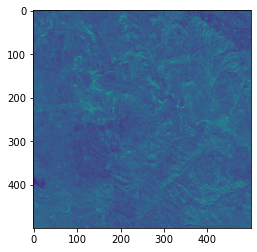

<AxesSubplot:>

In [15]:
from rasterio.plot import show
show(hls_out.isel(date=100, y=slice(500, 1000), x=slice(1000, 1500))['BLUE'].data)

In [19]:
hls_out = hls_out.chunk({'date': -1, 'y': 400, 'x': 400})

In [22]:
hls_ds2 = hls_out.map_blocks(drop_dup_time, template=hls_out.sortby('date').drop_duplicates('date', keep='first'))

/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [24]:
hls_ds2.to_zarr(os.path.join(outDIR,
                              prefix + 
                              '_hls_tmp/hls_ds_' + 
                              str(yr) +'_' + 
                              datetime.now().strftime('%Y%m%d') + '_cln.zarr'),
              mode = 'w',
               consolidated=True,)

NotImplementedError: Specified zarr chunks encoding['chunks']=(1, 2388, 2324) for variable named 'VZA' would overlap multiple dask chunks ((171,), (400, 400, 400, 400, 400, 388), (400, 400, 400, 400, 400, 324)). Writing this array in parallel with dask could lead to corrupted data. Consider either rechunking using `chunk()`, deleting or modifying `encoding['chunks']`, or specify `safe_chunks=False`.

In [8]:
#hls_ds = hls_ds.loc[dict(x=slice(517587.0, 527283.0), y=slice(4524402.0, 4514699.0))].chunk({'y': -1,
#                                                                                             'x': -1,
#                                                                                             'time':1})
#hls_mask = mask_hls(hls_ds['FMASK'])
print('   fetching data...')
t1 = time.time()
idx_load_try = 0
max_load_try = 5
while idx_load_try < max_load_try:
    try:
        # pick best image for any dates with duplicate images
        if len(np.unique(hls_ds.values)) < len(hls_ds.time.values):
            print('    reducing along id dimension to single observation for each date, keeping least-masked image')
            hls_ds = hls_ds.map_blocks(drop_dup_time, template=hls_ds.sortby('time').drop_duplicates('time', keep='first'))
            
        idx_load_try = max_load_try
    except RuntimeError as e:            
        if e.args[0] == 'Set changed size during iteration':
            print('Warning: error with cluster set size. Restarting cluster and retrying ' + \
              str(idx_load_try+1) + ' of ' + str(max_load_try))
            clust.close()
            client.close()
            clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            interface='ib0',
                            #interface='enp24s0f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
            client=Client(clust)
            #Scale Cluster 
            clust.scale(jobs=num_jobs)
            try:
                client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
            except dask.distributed.TimeoutError as e:
                print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
                #print(e)
                pass
            display(client)
        else:
            print('Warning: error connecting to lpdaac. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
            client.restart()
        idx_load_try += 1
    except rio.errors.RasterioIOError as e:
        print('Warning: error loading data. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
        client.restart()
        idx_load_try += 1

#hls_ds['time'] = hls_ds['time'].dt.date
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   fetching data...
    reducing along id dimension to single observation for each date, keeping least-masked image
...completed in 0.0 secs
total elasped time: 0.93 mins



/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

In [9]:
# convert time to datetime
hls_ds['time'] = pd.to_datetime(hls_ds.time)

In [10]:
# drop spec attribute for writing to NETCDF
hls_ds.attrs = {k: hls_ds.attrs[k] for k in hls_ds.attrs if k != 'spec'}

In [ ]:
if not os.path.exists(os.path.join(outDIR, prefix + '_hls_tmp/')):
        os.mkdir(os.path.join(outDIR, prefix + '_hls_tmp/'))
hls_ds.to_zarr(os.path.join(outDIR,
                              prefix + 
                              '_hls_tmp/hls_ds_' + 
                              str(yr) +'_' + 
                              datetime.now().strftime('%Y%m%d') + '.zarr'))

In [11]:
hls_ds.to_netcdf(os.path.join(outDIR,
                              prefix + 
                              '_hls_tmp/hls_ds_' + 
                              str(yr) +'_' + 
                              datetime.now().strftime('%Y%m%d') + '.nc'))

In [12]:
hls_ds

<xarray.Dataset>
Dimensions:      (time: 82, y: 323, x: 323)
Coordinates:
  * time         (time) datetime64[ns] 2021-11-03 2021-11-04 ... 2022-07-02
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
Data variables:
    BLUE         (time, y, x) float64 718.0 744.0 741.0 ... 910.0 870.0 821.0
    GREEN        (time, y, x) float64 1.053e+03 1.078e+03 ... 1.157e+03
    RED          (time, y, x) float64 1.39e+03 1.432e+03 ... 1.543e+03 1.45e+03
    NIR1         (time, y, x) float64 2.023e+03 2.132e+03 ... 2.623e+03
    SWIR1        (time, y, x) float64 2.468e+03 2.711e+03 ... 3.802e+03
    SWIR2        (time, y, x) float64 1.721e+03 1.903e+03 ... 2.815e+03
    FMASK        (time, y, x) float64 64.0 64.0 64.0 64.0 ... 128.0 128.0 128.0
    SZA          (time, y, x) float64 5.815e+03 5.815e+03 ... 2.305e+03
    SAA          (time, y, x) float64 1.614e+04 1.614e+04 ... 1.351e+04
    VZA          (time, y, x) float64 529.0 528.0 528.0 ... 959.0 958.0 958.0
    VAA          (time, y, x) float64 1.007e+04 1.007e+04 ... 9.461e+03
    maskcov_pct  (time) float64 0.01342 65.75 0.01054 97.3 ... 9.982 1.559 5.49
Attributes:
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 517590.00|\n| 0.00,-30.00, 4524390.00|\n| 0.0...
    resolution:  30